# Coronavirus COVID-19 project
Objective: Find interesting positions based on the multiple alignment files

In [15]:
# Read fasta file

def read_fasta(fasta_file):

    fasta_dict = dict()
    with open (fasta_file, 'r') as f:
        lines = f.readlines()

        for line in lines:
            if '>' in line:
                key = line[1:-1]
                fasta_dict[key] = ''
            else:
                fasta_dict[key] += line[:-1]
    return fasta_dict

# Read aligned fasta file
aligned_fasta = '../dataset/regional_sequences/multiple_regional_sequences_aligned.fasta'
aligned_dict = read_fasta(aligned_fasta)

# Read unaligned fasta
unaligned_fasta = '../dataset/regional_sequences/multiple_regional_sequences_unaligned.fasta'
unaligned_dict = read_fasta(unaligned_fasta)

In [3]:
# Get accession names and prepare numpy array
import numpy as np

accession_array = []
aligned_seq_array = []
for name, sequence in aligned_dict.items():
    aligned_seq_array.append(list(sequence))
    accession_array.append(name.split('|')[0][:-1])
    
aligned_seq_array = np.array(aligned_seq_array)
accession_array = np.array(accession_array)

In [46]:
# Replace non A,T,G,C with -

aligned_seq_array = np.where(np.isin(aligned_seq_array, ['A', 'T', 'G', 'C']), aligned_seq_array, '-')

In [47]:
aligned_ref = aligned_seq_array[0, :]
unaligned_ref = np.array(list(unaligned_dict['NC_045512 |Severe acute respiratory syndrome coronavirus 2 isolate Wuhan-Hu-1| complete genome']))

In [53]:
# Get the dictionary of key ref. aligned position sequance, value reference actual position
aligned_pos_translator = dict() # Translate aligned index to unaligned position
ptr_1 = 0
ptr_2 = 0

while ptr_2 < len(unaligned_ref):
    if aligned_ref[ptr_1] == unaligned_ref[ptr_2]:
        aligned_pos_translator[ptr_1] = ptr_2
        
        ptr_1 += 1
        ptr_2 += 1
    
    else:
        ptr_1 += 1

unaligned_pos_translator = dict() # Make the opposite dictionary
for key, value in list(aligned_pos_translator.items()):
    unaligned_pos_translator[value] = key


In [57]:
# Count the bases on each position, then calculate the non NA ratios
# For each position, count how many As, Ts, Gs, Cs, and -s, represent them in a 5-dimensional vector with counts of A,T,G,C and - respectively.
def count_bases(position_vector):
    count_vector = np.zeros(5)
    bases = ['A', 'T', 'G', 'C', '-']
    
    for i in range(len(bases)):
        base = bases[i]
        
        # Filter
        base_filter = position_vector == base
        count_vector[i] += len(position_vector[base_filter])
    
    return count_vector

# Use count_bases()

base_counts = []
for pos in range(aligned_seq_array.shape[1]):
    position_vec = aligned_seq_array[:, pos]
    
    base_counts.append(count_bases(position_vec))
base_counts = np.array(base_counts).transpose()

In [58]:
# Get the base proportions for all non-NA entries

base_proportions = []
for pos in range(base_counts.shape[1]):
    position_vec = base_counts[:4, pos]
    sum_current_vec = np.sum(position_vec)
    base_proportions.append(position_vec/sum_current_vec)

base_proportions = np.array(base_proportions).transpose()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


In [217]:
# Get variance for each spot
var_aligned = np.var(base_proportions, axis = 0)

unalign_mask = np.isin(np.array([i for i in range(len(aligned_ref))]), list(aligned_pos_translator.keys())) # Mask aligned
var_unaligned = var_aligned[unalign_mask]

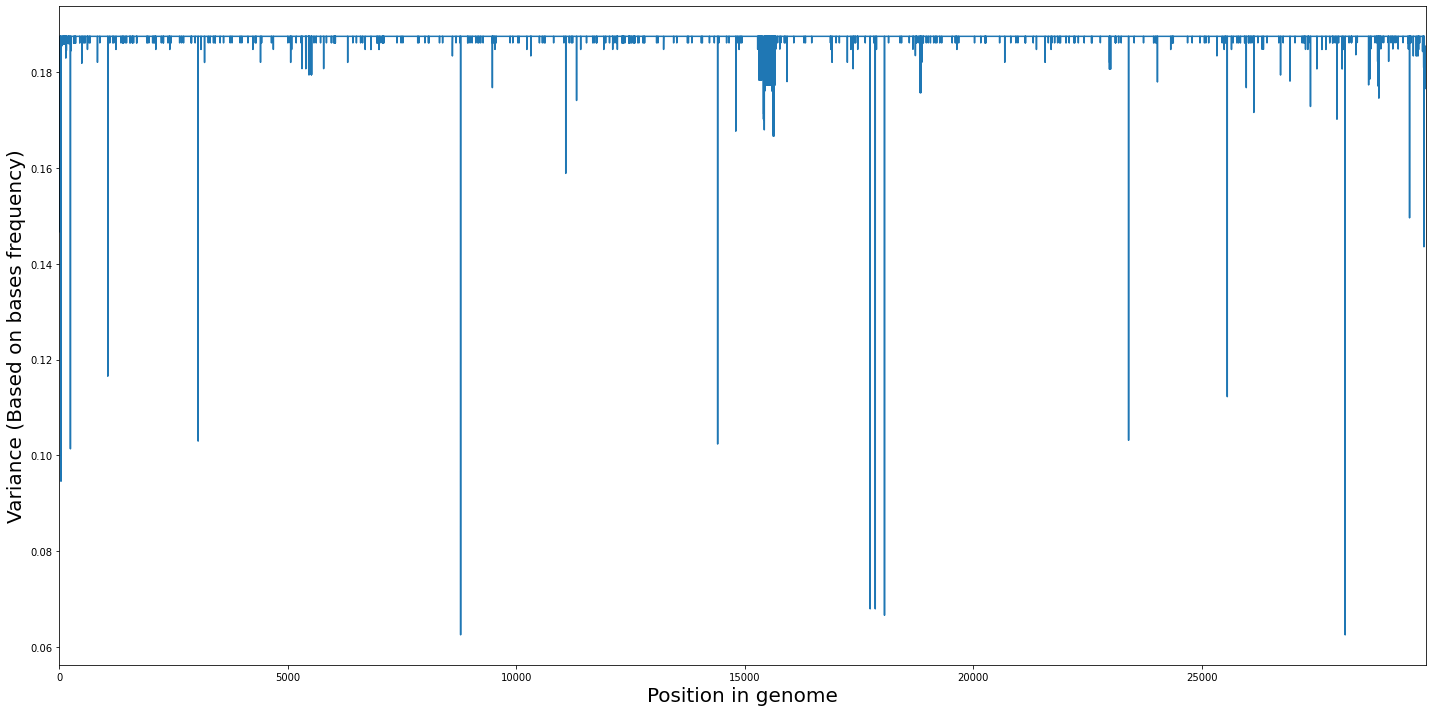

In [247]:
# Visualize variation in every spot

import matplotlib.pyplot as plt

def visualize_var(var_array):
    # Setup figure
    fig = plt.figure(figsize=(20, 10))
    plt.xlabel('Position in genome', size=20)
    plt.ylabel('Variance (Based on bases frequency)', size=20)
    plt.xlim((0, len(var_array)))
    
    # Prep data
    x_values = np.arange(len(var_array))
    y_values = var_array
    
    # Plot data
    plt.plot(x_values, y_values)
    plt.tight_layout()
    plt.savefig('../presentation/figures/variance_accross_genome.png')
    plt.show()
    
    
visualize_var(var_unaligned)

In [220]:
# Get interesting positions
low_var_pos_unaligned = np.where(var_unaligned < 0.16)

In [222]:
len(var_unaligned)

29903

In [231]:
import pandas as pd
gff_file = '../dataset/GCF_009858895.2_ASM985889v3_genomic.gff'
gff_df = pd.read_csv(gff_file, skiprows=7, sep='\t', names=['sequence','source','feature','start','end','score','strand','phase','attributes'])

def get_product(attribute):
    # Get product info from attribute
    # Split attribute
    att = attribute.split(';')
    # If ID=gene
    if 'ID=gene' in attribute:
        for sub_att in att:
            if 'gene=' in sub_att:
                gene_name = sub_att.split('=')[1]
                return gene_name
    
    elif 'ID=cds' in attribute:
        product_list = []
        for sub_att in att:
            if 'product' in sub_att:
                product = sub_att.split('=')[1]
                product_list.append(product)
            elif 'Note' in sub_att:
                note = sub_att.split('=')[1]
                product_list.append(note)
        return product_list
                

gff_df.loc[:, 'product'] = np.vectorize(get_product)(gff_df.loc[:, 'attributes'])


In [246]:
np.var([1,0,0,0])

0.1875

In [232]:
def search_feature(position, gff_df=gff_df):
    # Given reference unaligned position, output index of feature
    
    # Get filters
    start_filter = gff_df.loc[:, 'start'] <= position + 1
    end_filter = gff_df.loc[:, 'end'] >= position + 1
    comb_filter = start_filter & end_filter
    
    # Get products
    products = gff_df.loc[comb_filter, 'product'].values
    print(products)
    
    
    return products
    

In [233]:
low_var_pos_unaligned

(array([    0,    33,    34,    35,    36,   240,  1058,  3036,  8781,
        11082, 14407, 17746, 17857, 18059, 23402, 25562, 28143, 29552,
        29867]),)

In [234]:
np.vectorize(search_feature)(low_var_pos_unaligned)

[None None]
[None None]
[None None]
[None None]
[None None]
[None None]
[None None]
[None 'orf1ab'
 list(['pp1ab%3B translated by -1 ribosomal frameshift', 'orf1ab polyprotein'])
 list(['pp1a', 'orf1a polyprotein'])]
[None 'orf1ab'
 list(['pp1ab%3B translated by -1 ribosomal frameshift', 'orf1ab polyprotein'])
 list(['pp1a', 'orf1a polyprotein'])]
[None 'orf1ab'
 list(['pp1ab%3B translated by -1 ribosomal frameshift', 'orf1ab polyprotein'])
 list(['pp1a', 'orf1a polyprotein'])]
[None 'orf1ab'
 list(['pp1ab%3B translated by -1 ribosomal frameshift', 'orf1ab polyprotein'])
 list(['pp1a', 'orf1a polyprotein'])]
[None 'orf1ab'
 list(['pp1ab%3B translated by -1 ribosomal frameshift', 'orf1ab polyprotein'])]
[None 'orf1ab'
 list(['pp1ab%3B translated by -1 ribosomal frameshift', 'orf1ab polyprotein'])]
[None 'orf1ab'
 list(['pp1ab%3B translated by -1 ribosomal frameshift', 'orf1ab polyprotein'])]
[None 'orf1ab'
 list(['pp1ab%3B translated by -1 ribosomal frameshift', 'orf1ab polyprotein'])]


array([[array([None, None], dtype=object),
        array([None, None], dtype=object),
        array([None, None], dtype=object),
        array([None, None], dtype=object),
        array([None, None], dtype=object),
        array([None, None], dtype=object),
        array([None, 'orf1ab',
       list(['pp1ab%3B translated by -1 ribosomal frameshift', 'orf1ab polyprotein']),
       list(['pp1a', 'orf1a polyprotein'])], dtype=object),
        array([None, 'orf1ab',
       list(['pp1ab%3B translated by -1 ribosomal frameshift', 'orf1ab polyprotein']),
       list(['pp1a', 'orf1a polyprotein'])], dtype=object),
        array([None, 'orf1ab',
       list(['pp1ab%3B translated by -1 ribosomal frameshift', 'orf1ab polyprotein']),
       list(['pp1a', 'orf1a polyprotein'])], dtype=object),
        array([None, 'orf1ab',
       list(['pp1ab%3B translated by -1 ribosomal frameshift', 'orf1ab polyprotein']),
       list(['pp1a', 'orf1a polyprotein'])], dtype=object),
        array([None, 'orf1ab',

In [238]:
aligned_seq_array.shape

(436, 30025)